In [4]:
import os
import pandas as pd

# ingore future warning
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
# surprass chain warning
pd.set_option('mode.chained_assignment', None)
#warnings.filterwarnings("ignore", message=r"Passing", category=SettingWithCopyWarning)

print("Set the printing size of the pandas df... ")
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Set the printing size of the pandas df... 


In [5]:
# Plan to test 

# 0. The alignment of D1, D2 curves 

# 1. Ampltitude, frequency of four original curves and linear predict locomotion 
# (normalized curves, FFT, programatical methods)

# 2. Ampltitude, frequency of D1, D2 curves and linear predict locomotion 
# (normalized curves, FFT, programatical methods)



# Load in data

### Reload from here

In [6]:
# get the path
path = os.getcwd()
files = os.listdir(path + '/data/excel/')

# filter excel
files_xlsx = [f for f in files if f[-4:] == 'xlsx']

# read excel
xls = pd.ExcelFile('data/excel.xlsx')
# init ls 
ls_pds = [] 
# looping sheets
for n in range(69):
    df = pd.read_excel(xls, 'sheet%s'%n)
    ls_pds.append(df)

# Load in labels

Obtain the binary label:  [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


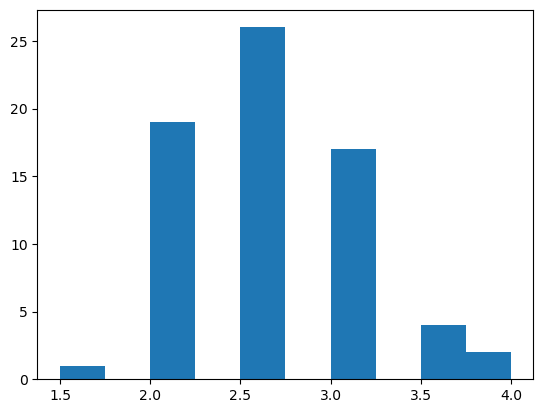

In [7]:
# load from excel 
labels_12 = pd.read_excel('data/NRS_LABEL.xlsx')

# get index for each example
idx = [i for i in range(len(files_xlsx))]
ls_idx = [12*i for i in idx]
#print("ls_idx: ", ls_idx)

# get every 12 labels (because each repeats 12 times)
labels = labels_12.iloc[ls_idx, :]

# sort by the first columns
labels_sort = labels.sort_values(labels.columns[0])
# add col 
labels_sort['name'] = files_xlsx
# print(labels_sort)

# label list 
labels_ls = labels_sort['nrs-score'].tolist()
import matplotlib.pyplot as plt
# plot histogram
plt.hist(labels_ls, density=False)

# get a binary list
binary_ls = [1 if i>=3 else 0 for i in labels_ls]
print("Obtain the binary label: ", binary_ls)

# Normalization: de-trend for each wave

### Two curves (D1: B4-B3, D2: B1-B2)

In [28]:
""" 
func: 
    called by normalize a wave curve
args: 
    temp_ls: pd series
"""
def one_wave(temp_ls, plot=False):
    temp_ls = temp_ls.reset_index(drop=True)
    #plt.plot(temp_ls)

    # get long-term trend
    long_trend = temp_ls.rolling(50, center=True).mean()
    
    # get average of the long_trend 
    mid_trend = long_trend.mean()
    mid_trend_ls = [mid_trend for i in range(len(long_trend))]

    # get diff: (diff: long_trend - mid_trend_ls)
    diff = long_trend - mid_trend_ls
    
    # result
    ls_sub = temp_ls - diff
    # drop nan
    ls_sub = ls_sub.dropna()
    
    if plot: 
        plt.plot(temp_ls, label='original')
        plt.plot(long_trend, label='long_trend')
        plt.plot(mid_trend_ls, label='average')
        plt.plot(diff, label='diff')
        plt.plot(ls_sub, label='result')
        plt.legend()
        plt.show()
        
    # return the normalized
    return ls_sub.tolist()

""" 
func: 
    normalize a wave curve 
arg: 
    test: pd df 
    PLOT: bool
return: 
    series changed
"""
def normalize_wave(test, PLOT=False):
    
    # create D1 and D2
    test['D1'] = test['Z-B4'] - test['Z-B3']
    test['D2'] = test['Z-B2'] - test['Z-B1']
    
    # init an pandas
    df = pd.DataFrame() 
    
    # normalize D1
    temp_ls = test['D1']
    df['D1_nor'] = one_wave(temp_ls, plot=PLOT)

    # normalize D2
    temp_ls_2 = test['D2']
    df['D2_nor'] = one_wave(temp_ls_2, plot=PLOT)

    return df

In [29]:
# init pds_nor
pds_nor = []
print("store normalized D in pds_nor")
# looping
for i in range(len(ls_pds)):
    #print("---------- ", binary_ls[i], " ------------")
    #print("---------- ", files_xlsx[i], " ------------")
    """using func: normalize_wave"""
    one_ex = normalize_wave(ls_pds[i], PLOT=False)
    pds_nor.append(one_ex)

store normalized D in pds_nor


### Visualize again after normalization

# Extract wave-related variables

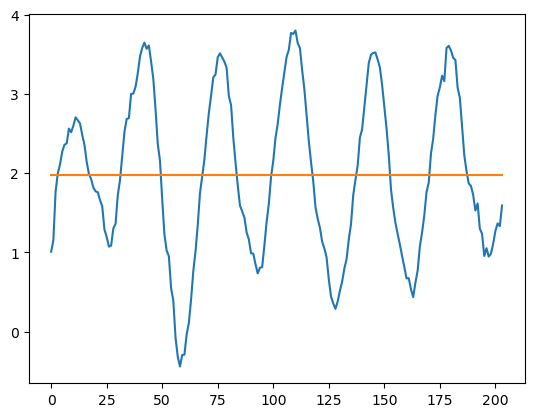

In [30]:

wave = pds_nor[0]['D1_nor'].tolist()
mean = pds_nor[0]['D1_nor'].mean()
mean_ls = [mean for i in range(len(wave))]
plt.plot(wave)
plt.plot(mean_ls)

In [31]:
"""
func: 
    to analysis one wave 
    called by others
args: 
    wave: list[float]
    mean: float
return: 
    amp_f, lev_f, freq_f: float
"""
def analyze_wave(wave, mean):
    
    # check 
    #print("len(wave): ", len(wave))
    #print("wave: ", wave)

    # to ensure the each period starts at increasing point 
    # the sign has to from neg to pos
    # this point has condition: now is pos but has previous neg values 
    for i in range(1, len(wave)):
        
        #print("min(wave[:i]): ", min(wave[:i]))
        if (wave[i] < mean) and (wave[i+1] > mean) and (min(wave[:i])<mean):
            wave = wave[i:]
            break

    # find the intersection points by the change of sign
    # bool
    sign = (wave[0]>mean)
    # init list to store idx
    idx_ls = []
    # loop wave
    for i in range(len(wave)): 
        # dynamic sign 
        sign_dyn = (wave[i]>mean) 
        # compare sign 
        if sign != sign_dyn: 
            # append
            idx_ls.append(i)
            # reset sign 
            sign = ~sign

    #print(idx_ls, len(idx_ls))
    # init amp, level, freq
    amp, lev, freq = [], [], []

    # now for each three points, we have a period 
    # looping period by idx
    for idx in range(0, len(idx_ls)-2, 2): 
        # this is the index for periods
        id1, id2, id3 = idx_ls[idx], idx_ls[idx+1], idx_ls[idx+2]
        # amp
        amp.append( (max(wave[id1:id2])-mean) + (mean-min(wave[id2:id3])) )
        # level 
        lev.append( sum(wave[id1:id3])/len(wave[id1:id3]) )
        # freq 
        freq.append( 1/(id3-id1) )

    #print("amp, lev, freq: ", amp, lev, freq)
    amp_f, lev_f, freq_f = sum(amp)/len(amp), sum(lev)/len(lev), sum(freq)/len(freq)

    return amp_f, lev_f, freq_f
    

In [32]:
"""
func: 
    extract variables from each wave 
args: 
    pds_nor: list[df]
return: 
    D1_var, D2_var, Diff: list[float]
"""
def extract_var(pds_nor):
    
    # init D1_variable, ...
    D1_var, D2_var, Diff = [], [], []

    # looping pds_nor
    for df_idx in range(len(pds_nor)): 
        
        # obtain the list of wave and mean 
        wave = pds_nor[df_idx]['D1_nor'].tolist()
        mean = pds_nor[df_idx]['D1_nor'].mean()
        """using func: """
        amp_f_1, lev_f_1, freq_f_1 = analyze_wave(wave, mean)
        # append 
        D1_var.append([amp_f_1, lev_f_1, freq_f_1])

        # obtain the list of wave and mean 
        wave = pds_nor[df_idx]['D2_nor'].tolist()
        mean = pds_nor[df_idx]['D2_nor'].mean()
        """using func: """
        amp_f_2, lev_f_2, freq_f_2 = analyze_wave(wave, mean)
        # append 
        D2_var.append([amp_f_2, lev_f_2, freq_f_2])
        
        # append the diff
        Diff.append([amp_f_1-amp_f_2, lev_f_1-lev_f_2, freq_f_1-freq_f_2])
        
    #print("D1_var, D2_var, Diff: ", D1_var, D2_var, Diff)
    return D1_var, D2_var, Diff

In [33]:
"""using func: """
D1_var, D2_var, Diff = extract_var(pds_nor)


### Plot and examine these variables

In [34]:
# e.g. diff of amp, diff of level 
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from pylab import figure

""" 
args: 
    np_data: 2d array
    dim1, dim2: int (columns index in np_data for plotting)
    label_str: list[str]
"""
def plot_2d_scatter(np_data, dim1, dim2, label_str):
    scatter_x = np_data[:, dim1]
    scatter_y = np_data[:, dim2]
    group = np.array(binary_ls)
    cdict = {0: 'forestgreen', 1: 'indigo'}

    fig, ax = plt.subplots()
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)

    plt.xlabel(label_str[dim1])
    plt.ylabel(label_str[dim2])
    ax.legend()
    plt.show()
    

"""
func: 

args: 
    np_data: 2d np array
"""
def plot_3d(np_data):
    fig = figure()
    ax = fig.add_subplot(projection='3d')

    scatter_x = np_data[:, 2]
    scatter_y = np_data[:, 1]
    scatter_z = np_data[:, 0]
    group = np.array(binary_ls)
    cdict = {0: 'forestgreen', 1: 'indigo'}

    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g, s = 100)

    ax.legend()
    plt.show()

### Experimenting

Obtain the binary label:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


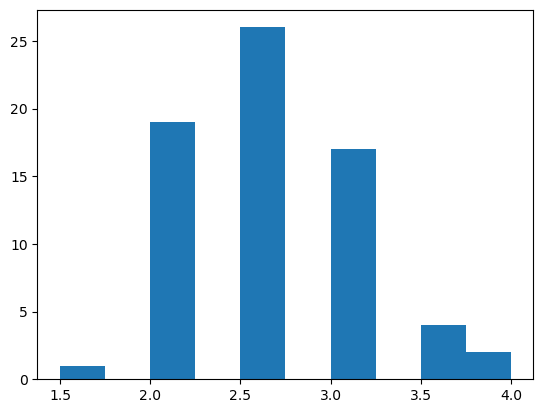

In [35]:

# plot histogram
plt.hist(labels_ls, density=False)
# get a binary list
binary_ls = [1 if i>=3.5 else 0 for i in labels_ls]
print("Obtain the binary label: ", binary_ls)

amp v.s. level


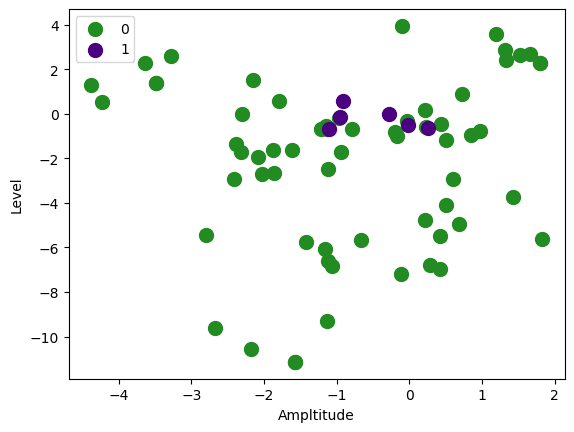

level v.s. freq


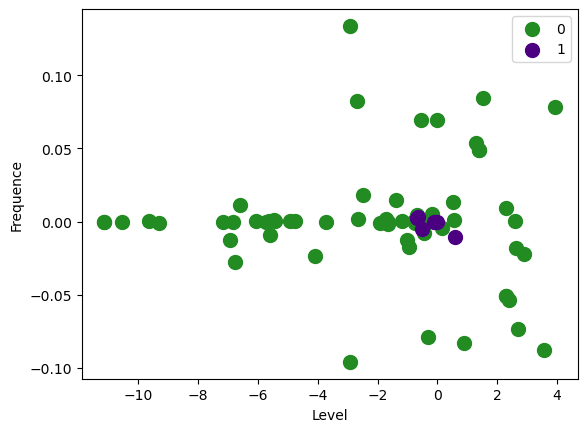

amp v.s. freq


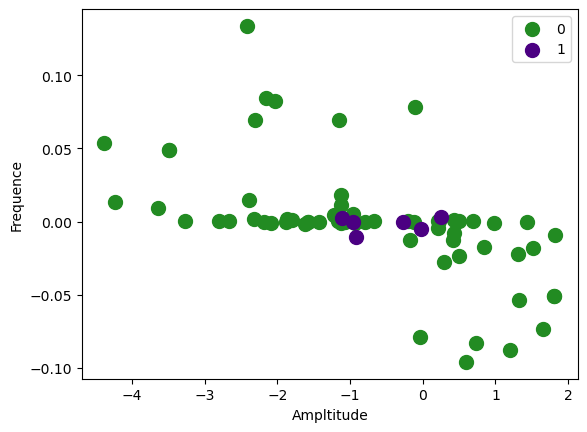

plot 3d


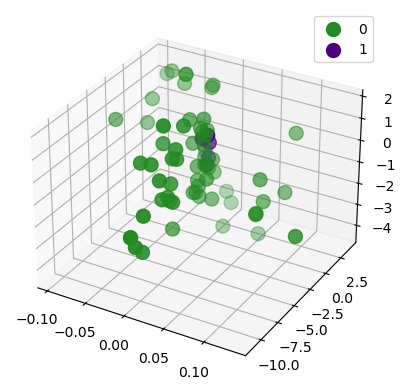

In [36]:
import numpy as np
# define input data for visualization 
np_data = np.array(Diff)
# init labels 
label_str = ['Ampltitude', 'Level', 'Frequence']
"""using func: """
print("amp v.s. level")
plot_2d_scatter(np_data, 0, 1, label_str)
print("level v.s. freq")
plot_2d_scatter(np_data, 1, 2, label_str)
print("amp v.s. freq")
plot_2d_scatter(np_data, 0, 2, label_str)
print("plot 3d")
plot_3d(np_data)

### Results: find the center of the positive examples and obtain y_pred`

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [38]:
# init x, y, z coordinates as list
x, y, z = [], [], []
# loop np_data 
for i in range(np_data.shape[0]): 
    # base on labels 
    if binary_ls[i] == 1:
        # compute
        x.append(np_data[i, 0])
        y.append(np_data[i, 1])
        z.append(np_data[i, 2])

x, y, z = sum(x)/len(x), sum(y)/len(y), sum(z)/len(z)
print("x, y, z: ", x, y, z)

x, y, z:  -0.5022696587301626 -0.23013225295697878 -0.0017212730802796214


In [50]:
# init ls_euc for euclidean
ls_euc = [] 
# init for l1 list 
ls_l1 = []
# loop np_data 
for i in range(np_data.shape[0]): 
    # compute euclidean distance 
    euc_dis = (np_data[i, 0] - x)**2 + (np_data[i, 1] - y)**2 + (np_data[i, 2] - z)**2
    # compute the L1 distance 
    l1_dis = abs(np_data[i, 0] - x) + abs(np_data[i, 1] - y) + abs(np_data[i, 2] - z)
    # append 
    ls_euc.append(euc_dis)
    # append 
    ls_l1.append(l1_dis)

In [55]:
for i in range(len(binary_ls)):
    if binary_ls[i] == 1: 
        print(ls_euc[i])

0.21508520682303428
0.30139887998786263
0.0971212699759454
0.7483342120925565
0.8472813070029572
0.5700854077564559


In [57]:
# init se, sp, auc list 
se_ls, sp_ls, auc_ls = [], [], []
threshold_ls = [0.8, 0.85, 0.9, 0.95, 1.0]
for threshold in threshold_ls:
    # set prediction based on the threshold
    y_pred = [1 if abs(i) < threshold else 0 for i in ls_euc] 
    # set y test as our target
    y_test = binary_ls
    auc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sp = tn / (tn + fp)
    se = tp / (tp + fn)
    # appending 
    se_ls.append(se) 
    sp_ls.append(sp) 
    auc_ls.append(auc)

    print("sp, se, auc: ", sp, se, auc)

sp, se, auc:  0.8412698412698413 0.8333333333333334 0.8373015873015874
sp, se, auc:  0.8412698412698413 1.0 0.9206349206349207
sp, se, auc:  0.8412698412698413 1.0 0.9206349206349207
sp, se, auc:  0.8253968253968254 1.0 0.9126984126984127
sp, se, auc:  0.8253968253968254 1.0 0.9126984126984127


### PLot the results

In [65]:
# rounding
auc_ls = [round(i, 2) for i in auc_ls]
se_ls = [round(i, 2) for i in se_ls]
sp_ls = [round(i, 2) for i in sp_ls]
threshold_ls = [round(i, 2) for i in threshold_ls]

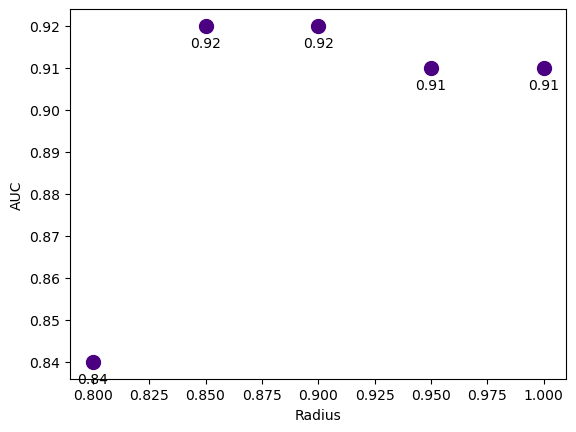

In [73]:
""" 
func: 
    to write the label on plots 
args: 
    dates, temp: list of x and y in the plot 
    plt: the plot object
return: 
    annotated plot
"""
def write_label(dates, temp, plt, position='none'): 
    for x, y in zip(dates, temp):
        label = y

        plt.annotate(label, (x, y),
            xycoords="data",
            textcoords="offset points",
            xytext=(0, -15), ha="center")
    
plt.ylabel("AUC")
plt.xlabel("Radius")
"""using func: """
write_label(threshold_ls, auc_ls, plt)
plt.scatter(threshold_ls, auc_ls, color="indigo", s=100)